In [1]:
# This code uses CNN to train a model to play chess.
# The dataset is obtained from kaggle

In [2]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as transforms
import torch.nn.functional as F

# Getting Data

In [3]:
import pandas as pd
num_train = 55000
num_epochs = 100

df = pd.read_csv('train.csv')
train_df = pd.read_csv('train.csv')

# choose num_train as training data
train_df = train_df.iloc[:num_train]

# remaining data is evaluation data
valid_df = pd.read_csv('train.csv').iloc[num_train:]
print(df)
#print(min(df['black_score']))

          id                                              board  black_score  \
0      80091               6R1/8/5K2/8/5k2/8/8/2r5 w - - 89 118          0.0   
1      18578  r1bn1rk1/1p2b1p1/1q2p2p/p2p1p1n/P2P3P/2PB1N2/1...       -131.0   
2      11580  r2qkb1r/2p2pp1/p1n2nP1/1p1p3p/P7/1Q5b/1PP1PPB1...       -490.0   
3      72805                  8/4kp2/R6p/8/4K3/8/8/8 b - - 7 85       -574.0   
4      74310                 8/8/k7/4R3/8/6K1/8/1r6 w - - 99 90          0.0   
...      ...                                                ...          ...   
58780  71594                  3b4/8/8/4kB2/8/8/4K3/8 b - - 2 81          0.0   
58781  75035                   8/8/R5KP/8/8/pk5r/8/8 w - - 5 92          0.0   
58782   4412  rnbqk1nr/pp2ppbp/6p1/3p4/2pP4/4PN1P/PPP1BPP1/R...        -78.0   
58783  18721  r2qbrk1/2p3p1/p4n2/2bp2Bp/Pp1n4/3Q3P/1PPNPPB1/...       -194.0   
58784  56466          8/5pk1/R3r2p/P6P/8/4P1K1/5P2/8 w - - 3 53       -699.0   

      best_move  
0          g8d8  
1  

In [4]:
import chess

def piece_value(piece):
    piece_map = {
        '.': 0,
        'r': 5,
        'b': 3.2,
        'n': 3,
        'p': 1,
        'k': 4,
        'q': 9
    }

    lower_piece = piece.lower()
    for symbol, value in piece_map.items():
        if lower_piece == symbol:
            if piece.islower():
                # White pieces
                return value 
            else:
                # Black pieces
                return -value
    # Unknown piece
    return 0

def fen_to_matrix(fen):
    #print(fen)
    # Getting names of pieces
    board = chess.Board(fen)
    #print("board before replacing\n", board)
    #gets rid of spaces and newline characters
    str_board = str(board).replace(' ', '').replace('\n', '')
    #print("board after replacing", str_board)
    
    values_list = []
    for char in str_board:
      values_list.append(piece_value(char))
    # Add channel dimension since pytorch CNNS expect (batch_size, channels, height, width)
    return np.array(values_list).reshape(1, 8, 8)

def create_dataset(df):
    input_list = []
    for fen in df['board']:
        arr = fen_to_matrix(fen)
        input_list.append(arr)
    inputs = np.stack(input_list)
    scores = df['black_score'].values

    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    targets_tensor = torch.tensor(scores, dtype=torch.float32).unsqueeze(1)
    return inputs_tensor, targets_tensor

# Creating DataSet

In [5]:
class ChessDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.inputs, self.targets = create_dataset(df)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create the dataset
train_data = ChessDataset(train_df)
print(len(train_data))

valid_data = ChessDataset(valid_df)
print(len(valid_data))


55000
3785


# Creating CNN Module

In [6]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # 3 Convolutions layers with ReLU
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding='same'),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(8, 8)),
           
            # Linear layers - 1 hidden layer
            nn.Flatten(),     
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

## Creating CNN Module with ResNet


In [7]:
class CNNResNet(nn.Module):

    class Block(nn.Module):
        def __init__(self, cin, cout):
            super().__init__()
            self.model = nn.Sequential(
                nn.Conv2d(cin, cin, 3, padding=1),
                nn.BatchNorm2d(cin),
                nn.ReLU(),
                nn.Conv2d(cin, cout, 3, padding=1),
            )
            if cin == cout:
                self.skip = nn.Identity()
            else:
                self.skip = nn.Conv2d(cin, cout, 1)

        def forward(self, x):
            return self.model(x) + self.skip(x)

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            CNNResNet.Block(1, 16),
            CNNResNet.Block(16, 16),
            CNNResNet.Block(16, 32),
            CNNResNet.Block(32, 32),
            CNNResNet.Block(32, 64),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(8, 8)),

            nn.Flatten(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)


# Training Loop


In [8]:
def train(lr=1e-3, epochs=100, batch_size=64):

    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(valid_data, shuffle=False, batch_size=batch_size)

    # Use Mean Squared Error Loss for regression task
    loss_fn = nn.MSELoss()
    # Adam
    opt = optim.Adam(model.parameters(), lr=lr)

    train_accs = []
    valid_accs = []

    for i in range(epochs):
        model.train()
        accs = []
        # iterate over batches
        for batch_xs, batch_ys in train_loader:
            # Forward pass through network
            preds = model(batch_xs)

            # Compute error between network output and label
            loss_val = loss_fn(preds, batch_ys) 

            # Track Loss
            accs.append(loss_val.item()) 

            # compute gradients of loss wrt parameters(weights, biases)
            opt.zero_grad()
            loss_val.backward()

            # Clip gradients to prevent exploding gradients
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            
            #this line changes the weights by applying the gradients
            opt.step() 

        train_accs.append(torch.tensor(accs).mean().item())
        model.eval()
        accs = []

        for batch_xs, batch_ys in valid_loader:
            preds = model(batch_xs)
            loss_val = loss_fn(preds, batch_ys)
            accs.append(loss_val.item())

        valid_accs.append(torch.tensor(accs).mean().item())
        print("Epoch:", i, "Validation Loss:", valid_accs[-1])

    return train_accs, valid_accs

# Creating Model and Starting Training

In [9]:
model = CNN()
train_accs, valid_accs = train(epochs=num_epochs)
# to use the CNNResNet model, uncomment the following two lines and comment the previous two
#model = CNNResNet()
#train_accs, valid_accs = train(epochs=num_epochs)

Epoch: 0 Validation Loss: 140358.59375
Epoch: 1 Validation Loss: 117831.1796875
Epoch: 2 Validation Loss: 105461.59375
Epoch: 3 Validation Loss: 97749.625
Epoch: 4 Validation Loss: 86347.4453125
Epoch: 5 Validation Loss: 87745.9921875
Epoch: 6 Validation Loss: 81077.859375
Epoch: 7 Validation Loss: 76869.5859375
Epoch: 8 Validation Loss: 74163.6953125
Epoch: 9 Validation Loss: 74241.609375
Epoch: 10 Validation Loss: 75531.3984375
Epoch: 11 Validation Loss: 71858.796875
Epoch: 12 Validation Loss: 68853.8046875
Epoch: 13 Validation Loss: 70909.3671875
Epoch: 14 Validation Loss: 70966.140625
Epoch: 15 Validation Loss: 70102.578125
Epoch: 16 Validation Loss: 68669.7421875
Epoch: 17 Validation Loss: 65513.13671875
Epoch: 18 Validation Loss: 65251.27734375
Epoch: 19 Validation Loss: 65091.08203125
Epoch: 20 Validation Loss: 63543.03515625
Epoch: 21 Validation Loss: 68729.9765625
Epoch: 22 Validation Loss: 64655.62890625
Epoch: 23 Validation Loss: 66050.7109375
Epoch: 24 Validation Loss: 6204

# Plotting Epoch vs. loss

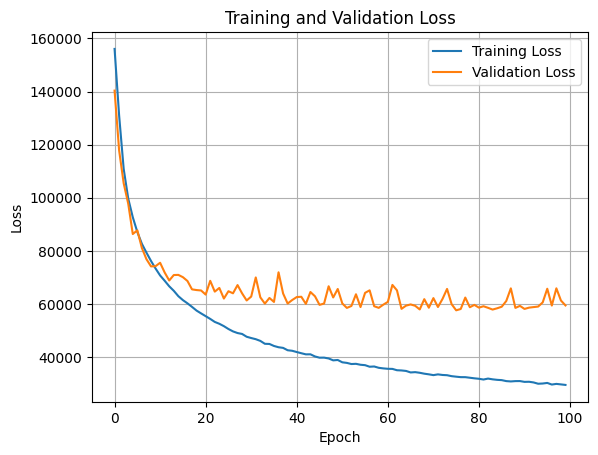

In [10]:
import matplotlib.pyplot as plt

def plot_loss():
    # Convert tensors to floats for plotting
    train_vals = [t.item() if hasattr(t, "item") else t for t in train_accs]
    valid_vals = [t.item() if hasattr(t, "item") else t for t in valid_accs]
    
    plt.plot(train_vals, label="Training Loss")
    plt.plot(valid_vals, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_loss()

# Display board and Playing after Training

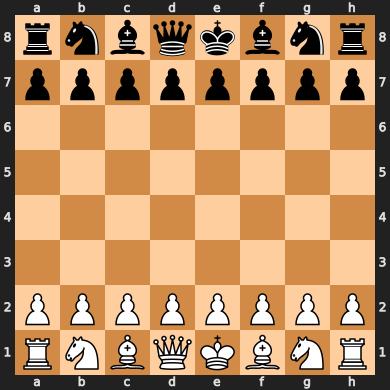

Your move (UCI format):  e2e4


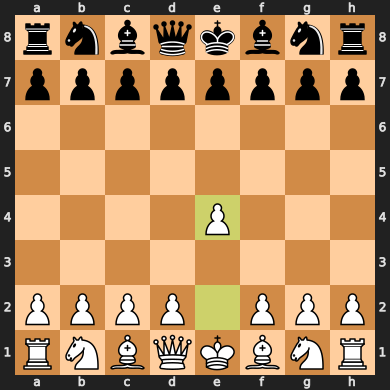

Computer moves: b8c6


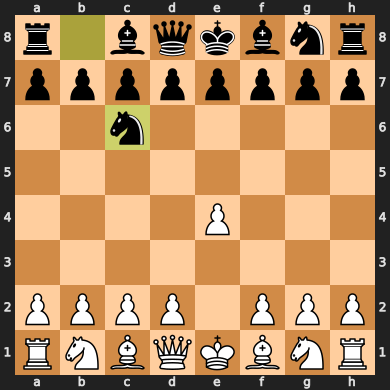

Your move (UCI format):  d2d4


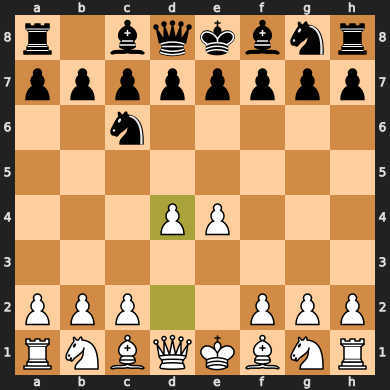

Computer moves: c6a5


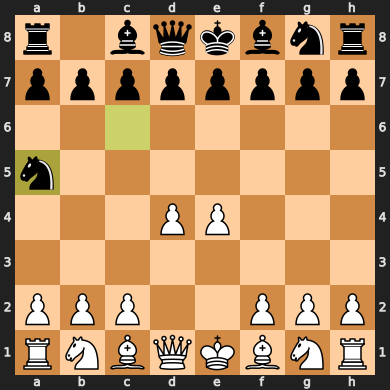

Your move (UCI format):  g1f3


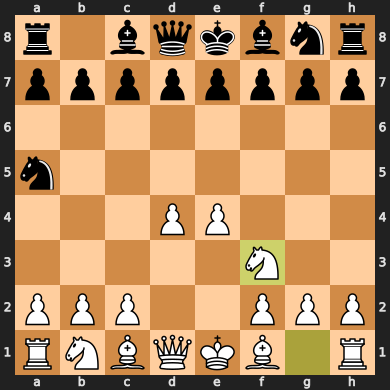

Computer moves: e7e6


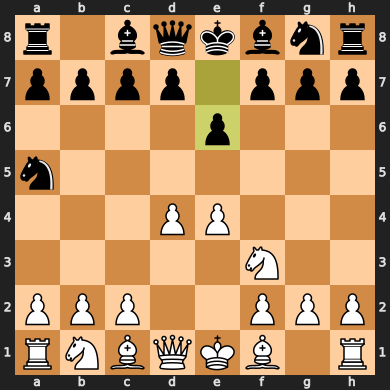

Your move (UCI format):  b1c3


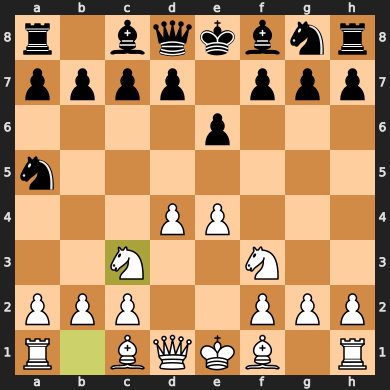

Computer moves: g8f6


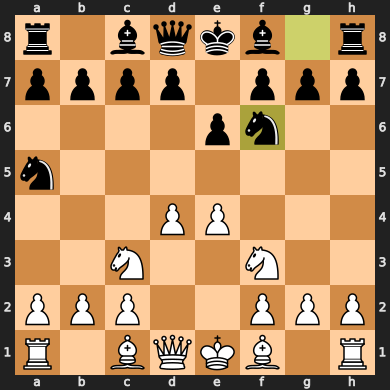

Your move (UCI format):  f1d3


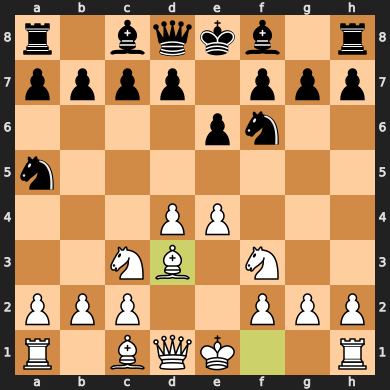

Computer moves: f6g8


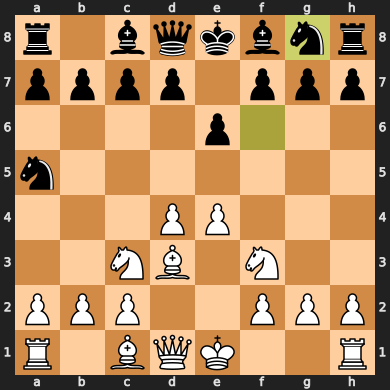

In [ ]:
import random
from IPython.display import display

def fen_to_vector(fen):
    # getting piece names
    board = chess.Board(fen)  
    
    #gets rid of spaces and newline characters
    str_board = str(board).replace(' ', '').replace('\n', '')

    # Convert each character to a numeric value
    int_board = [piece_value(char) for char in str_board]

    # Reshape the flat list into an 8x8 matrix
    matrix = np.array(int_board).reshape((8, 8))

    return matrix 

def get_score(model, board):
    int_board = fen_to_vector(board.fen())

    # Reshape to (1, 1, 8, 8)
    inputs = torch.tensor(int_board, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return model(inputs).item()

def get_best_move(model, current_board):
    legal_moves = list(current_board.legal_moves)
    scores = []
    for move in legal_moves:
        board = current_board.copy()
        board.push(move)
        scores.append(get_score(model, board))
    if current_board.turn == chess.WHITE:
        best = np.argmin(scores)
    else:
        best = np.argmax(scores)
    return legal_moves[best] 

def get_computer_move(board):
    # Returns a random legal move for the computer
    legal_moves = list(board.legal_moves)
    return random.choice(legal_moves)

def main():
    # Runs the chess game 
    board = chess.Board()
    display(board)

    while not board.is_game_over():
        if board.turn == chess.WHITE:
            # Human player's turn
            # clear_output(wait=True)
            move_uci = input("Your move (UCI format): ")
            try:
                move = chess.Move.from_uci(move_uci)
                if move in board.legal_moves:
                    board.push(move)
                    display(board)
                else:
                    print("Illegal move. Try again.")
            except ValueError:
                print("Invalid move format. Try again.")

        else:
            # Computer player's turn
            move = get_best_move(model, board)
            #move = get_computer_move(board)
            print(f"Computer moves: {move}")
            board.push(move)
            display(board)

    # Game over
    print("Game Over!")
    if board.result() == "1-0":
        print("White wins!")
    elif board.result() == "0-1":
        print("Black wins!")
    else:
        print("Draw!")


if __name__ == "__main__":
    main()

In [ ]:
board = chess.Board()
display(board)
print("Your move (UCI format): ", end="")
user_move = input()